In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import json
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import pickle
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
merged_d = pd.read_csv(r'/content/drive/MyDrive/Dissertation_10862121/merged_d.csv')

In [ ]:
merged_d['GMT'] = pd.to_datetime(merged_d['GMT'])
merged_d['Date'] = pd.to_datetime(merged_d['Date'])
merged_d.set_index('GMT', inplace=True)

In [ ]:
merged_d

,Total Household Consumption (D),Date,Time,Year,Month,Day,Hour,DayOfWeek,IsHoliday,Hourly Global Radiation (KJ/m2),...,Hourly Pressure at Mean Sea Level (hPa),Hourly Rainfall Total (mm),Hourly Relative Humidity (%),Hourly Snow Depth (cm),Hourly Temperature (C),Hourly Total Cloud Cover (oktas)\n,Hourly Visibility (dm),Low,Default,High
GMT,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,393.709000,2013-01-01,00:00:00,2013,1,1,0,1,True,0.0,...,999.400,0.00,92.085714,0.0,8.914286,8.000000,2133.333333,0,1,0
2013-01-01 01:00:00,327.556000,2013-01-01,01:00:00,2013,1,1,1,1,True,0.0,...,999.675,0.00,91.042857,0.0,8.785714,8.000000,1766.666667,0,1,0
2013-01-01 02:00:00,286.207000,2013-01-01,02:00:00,2013,1,1,2,1,True,0.0,...,999.975,0.20,92.685714,0.0,8.514286,8.000000,1333.333333,0,1,0
2013-01-01 03:00:00,250.964000,2013-01-01,03:00:00,2013,1,1,3,1,True,0.0,...,1000.725,0.96,89.871429,0.0,7.285714,7.666667,4100.000000,0,1,0
2013-01-01 04:00:00,233.412000,2013-01-01,04:00:00,2013,1,1,4,1,True,0.0,...,1001.300,0.08,88.585714,0.0,6.700000,4.000000,5500.000000,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,743.251693,2013-12-31,19:00:00,2013,12,31,19,1,False,0.0,...,1002.900,0.00,85.385714,0.0,5.942857,6.333333,3666.666667,0,1,0
2013-12-31 20:00:00,645.912531,2013-12-31,20:00:00,2013,12,31,20,1,False,0.0,...,1003.175,0.00,84.442857,0.0,5.442857,1.333333,4000.000000,0,1,0
2013-12-31 21:00:00,586.851605,2013-12-31,21:00:00,2013,12,31,21,1,False,0.0,...,1003.450,0.00,83.257143,0.0,5.414286,1.000000,3833.333333,0,1,0


Daily Dataframe

In [ ]:
#New DataFrame storing daily aggregated data
daily_d = merged_d.resample('D').agg({
    'Total Household Consumption (D)': 'sum',
    'Hourly Temperature (C)': 'mean',
    'Hourly Pressure at Mean Sea Level (hPa)': 'mean',
    'Hourly Global Radiation (KJ/m2)': 'mean',
    'Hourly Rainfall Total (mm)': 'mean',
    'Hourly Mean Wind Direction (o)': 'mean',
    'Hourly Mean Windspeed (kn)': 'mean',
    'Hourly Maximum Gust (kn)': 'mean',
    'Hourly Visibility (dm)': 'mean',
    'Hourly Relative Humidity (%)': 'mean',
    'Hourly Total Cloud Cover (oktas)\n': 'mean',
}).reset_index()

In [ ]:
#Non-aggregated columns
daily_d['Date'] = daily_d['GMT'].dt.date
daily_d['Month'] = daily_d['GMT'].dt.month
daily_d['Day'] = daily_d['GMT'].dt.day
daily_d['DayOfWeek'] = daily_d['GMT'].dt.dayofweek

In [ ]:
#Renaming the columns for the weather variables to indicate they now contain daily averages
daily_d.rename(columns={
    'Hourly Temperature (C)': 'Daily Temperature (C)',
    'Hourly Pressure at Mean Sea Level (hPa)': 'Daily Pressure at Mean Sea Level (hPa)',
    'Hourly Global Radiation (KJ/m2)': 'Daily Global Radiation (KJ/m2)',
    'Hourly Rainfall Total (mm)': 'Daily Rainfall Total (mm)',
    'Hourly Mean Wind Direction (o)': 'Daily Mean Wind Direction (o)',
    'Hourly Mean Windspeed (kn)': 'Daily Mean Windspeed (kn)',
    'Hourly Maximum Gust (kn)': 'Daily Maximum Gust (kn)',
    'Hourly Visibility (dm)': 'Daily Visibility (dm)',
    'Hourly Relative Humidity (%)': 'Daily Relative Humidity (%)',
    'Hourly Total Cloud Cover (oktas)\n': 'Daily Total Cloud Cover (oktas)'
}, inplace=True)

In [ ]:
#Calculating 'Peak Day Value' and 'Peak Day Hour'
max_consumption_idx = merged_d.groupby(merged_d.index.date)['Total Household Consumption (D)'].idxmax()
peak_values = merged_d.loc[max_consumption_idx, 'Total Household Consumption (D)']
peak_hours = merged_d.loc[max_consumption_idx, 'Hour']

In [ ]:
#Creating dictionaries for mapping
peak_values_dict = dict(zip(peak_values.index.date, peak_values.values))
peak_hours_dict = dict(zip(peak_hours.index.date, peak_hours.values))

#Merging 'Peak Day Value' and 'Peak Day Hour' into the daily_aggregated DataFrame
daily_d['Peak Day Value'] = daily_d['Date'].map(peak_values_dict)
daily_d['Peak Day Hour'] = daily_d['Date'].map(peak_hours_dict)


In [ ]:
daily_d.drop(columns=['GMT'], inplace=True)

In [ ]:
daily_d['Date'] = pd.to_datetime(daily_d['Date'])
daily_d.set_index('Date', inplace=True)

In [ ]:
#Converting the 'IsHoliday' column in merged_n to integer type for summation
merged_d['IsHoliday'] = merged_d['IsHoliday'].astype(int)

#Grouping by 'Date' and summing the 'IsHoliday' column
daily_holidays = merged_d.groupby('Date').agg({'IsHoliday': 'sum'})

#Converting the summed values to a binary (0 or 1) indicating presence of holiday
daily_holidays['IsHoliday'] = daily_holidays['IsHoliday'].apply(lambda x: 1 if x > 0 else 0)

daily_d['IsHoliday'] = daily_d.index.map(daily_holidays['IsHoliday']).fillna(0).astype(int)

In [ ]:
daily_d

,Total Household Consumption (D),Daily Temperature (C),Daily Pressure at Mean Sea Level (hPa),Daily Global Radiation (KJ/m2),Daily Rainfall Total (mm),Daily Mean Wind Direction (o),Daily Mean Windspeed (kn),Daily Maximum Gust (kn),Daily Visibility (dm),Daily Relative Humidity (%),Daily Total Cloud Cover (oktas),Month,Day,DayOfWeek,Peak Day Value,Peak Day Hour,IsHoliday
Date,,,,,,,,,,,,,,,,,
2013-01-01,11389.871000,5.991667,1007.663542,169.819444,0.053056,261.166667,8.700000,15.141667,3816.666667,81.655952,3.097222,1,1,1,776.241000,18,1
2013-01-02,11555.369000,6.440476,1023.133333,42.569444,0.022083,237.750000,7.083333,11.925000,2337.638889,91.691667,6.722222,1,2,2,788.050000,18,0
2013-01-03,11010.191000,10.262500,1032.562500,73.277778,0.000000,257.666667,8.525000,14.816667,2503.611111,92.282738,7.611111,1,3,3,780.390000,18,0
2013-01-04,11320.812000,9.350595,1037.157292,76.111111,0.001389,266.500000,8.466667,14.875000,2924.444444,85.682738,7.777778,1,4,4,764.900000,18,0
2013-01-05,11125.943000,8.830952,1035.168750,52.430556,0.000000,244.916667,6.508333,11.458333,2072.361111,92.425000,7.041667,1,5,5,775.334000,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-27,11310.611347,8.875595,987.026042,51.805556,0.201111,213.416667,15.400000,28.516667,1995.972222,75.789286,5.013889,12,27,4,723.673711,18,0
2013-12-28,10747.984432,5.114881,997.500000,139.125000,0.000000,229.916667,6.158333,10.891667,3338.888889,78.417262,2.847222,12,28,5,700.317915,18,0
2013-12-29,11502.317654,3.575000,1014.921875,177.194444,0.009722,232.000000,6.266667,10.800000,2831.944444,84.811905,0.916667,12,29,6,743.679319,18,0


Lags (Endogenous Variables)

In [ ]:
daily_d['lag_1_day_peak'] = daily_d['Peak Day Value'].shift(1)
daily_d['lag_2_day_peak'] = daily_d['Peak Day Value'].shift(2)
daily_d['lag_3_day_peak'] = daily_d['Peak Day Value'].shift(3)
daily_d['lag_4_day_peak'] = daily_d['Peak Day Value'].shift(4)
daily_d['lag_5_day_peak'] = daily_d['Peak Day Value'].shift(5)
daily_d['lag_6_day_peak'] = daily_d['Peak Day Value'].shift(6)
daily_d['lag_7_day_peak'] = daily_d['Peak Day Value'].shift(7)

In [ ]:
nan_rows = daily_d[daily_d.isna().any(axis=1)]
print(nan_rows)

            Total Household Consumption (D)  Daily Temperature (C)  \
Date                                                                 
2013-01-01                     11389.871000               5.991667   
2013-01-02                     11555.369000               6.440476   
2013-01-03                     11010.191000              10.262500   
2013-01-04                     11320.812000               9.350595   
2013-01-05                     11125.943000               8.830952   
2013-01-06                     11817.219630               7.158929   
2013-01-07                     11061.742111               7.730952   

            Daily Pressure at Mean Sea Level (hPa)  \
Date                                                 
2013-01-01                             1007.663542   
2013-01-02                             1023.133333   
2013-01-03                             1032.562500   
2013-01-04                             1037.157292   
2013-01-05                             1035.1

In [ ]:
daily_d.dropna(inplace=True)

Decomposition

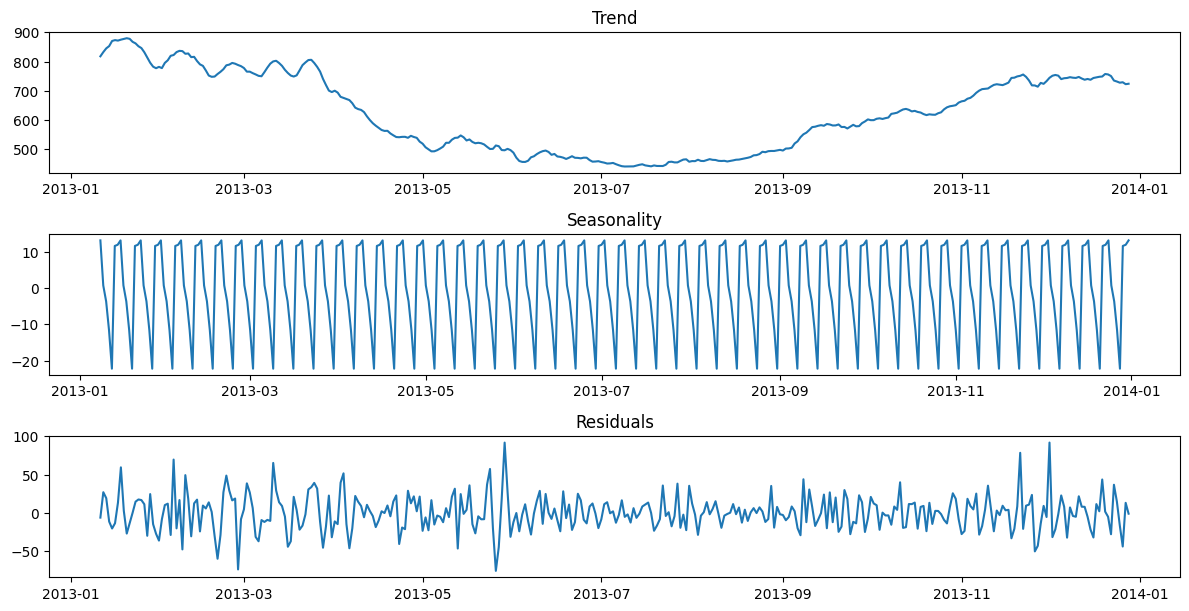

In [ ]:
decomposition = seasonal_decompose(daily_d['Peak Day Value'], model='additive')

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(decomposition.trend)
plt.title('Trend')

plt.subplot(4, 1, 2)
plt.plot(decomposition.seasonal)
plt.title('Seasonality')

plt.subplot(4, 1, 3)
plt.plot(decomposition.resid)
plt.title('Residuals')

plt.tight_layout()
plt.show()

Differencing

ADF Statistic before differencing: -1.8045685236036324
p-value before differencing: 0.37819591901757066
ADF Statistic after differencing: -5.830802219196097
p-value after differencing: 3.979442064215386e-07


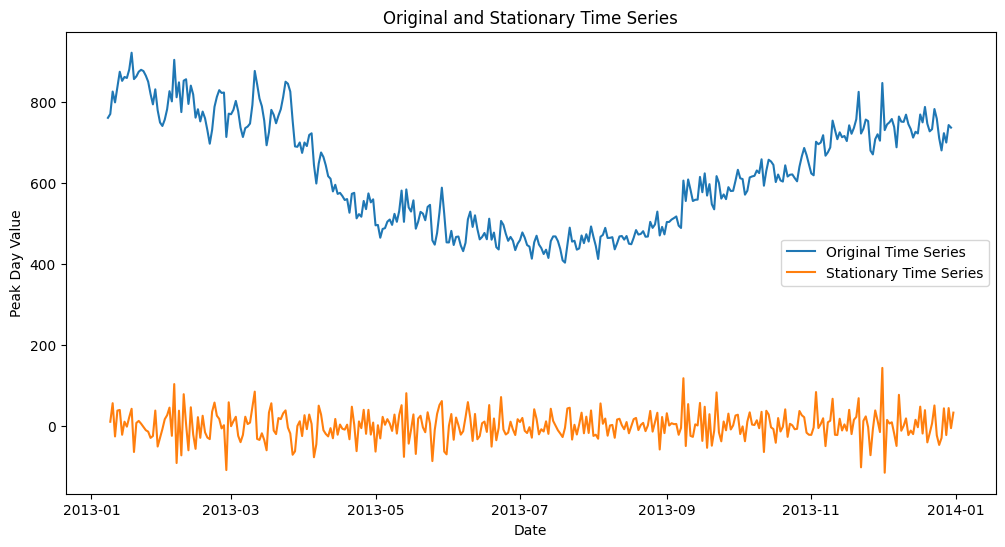

In [ ]:
#Augmented Dickey-Fuller test to check for stationarity before differencing
result_before_diff = adfuller(daily_d['Peak Day Value'].dropna())
print('ADF Statistic before differencing:', result_before_diff[0])
print('p-value before differencing:', result_before_diff[1])

#Differencing to make the time series stationary
stationary_peak_day_value = daily_d['Peak Day Value'].diff().dropna()

#Augmented Dickey-Fuller test again to check for stationarity after differencing
result_after_diff = adfuller(stationary_peak_day_value)
print('ADF Statistic after differencing:', result_after_diff[0])
print('p-value after differencing:', result_after_diff[1])

plt.figure(figsize=(12, 6))
plt.plot(daily_d.index[:-1], daily_d['Peak Day Value'].values[:-1], label='Original Time Series')
plt.plot(daily_d.index[1:], stationary_peak_day_value.values, label='Stationary Time Series')
plt.xlabel('Date')
plt.ylabel('Peak Day Value')
plt.title('Original and Stationary Time Series')
plt.legend()
plt.show()

ACF and PACF

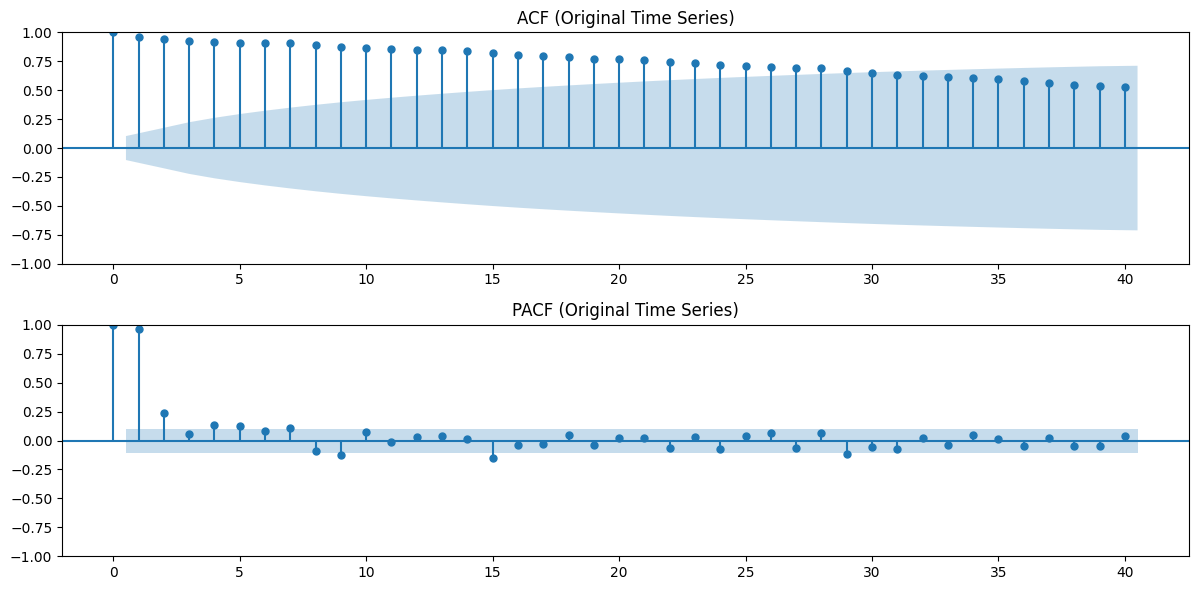

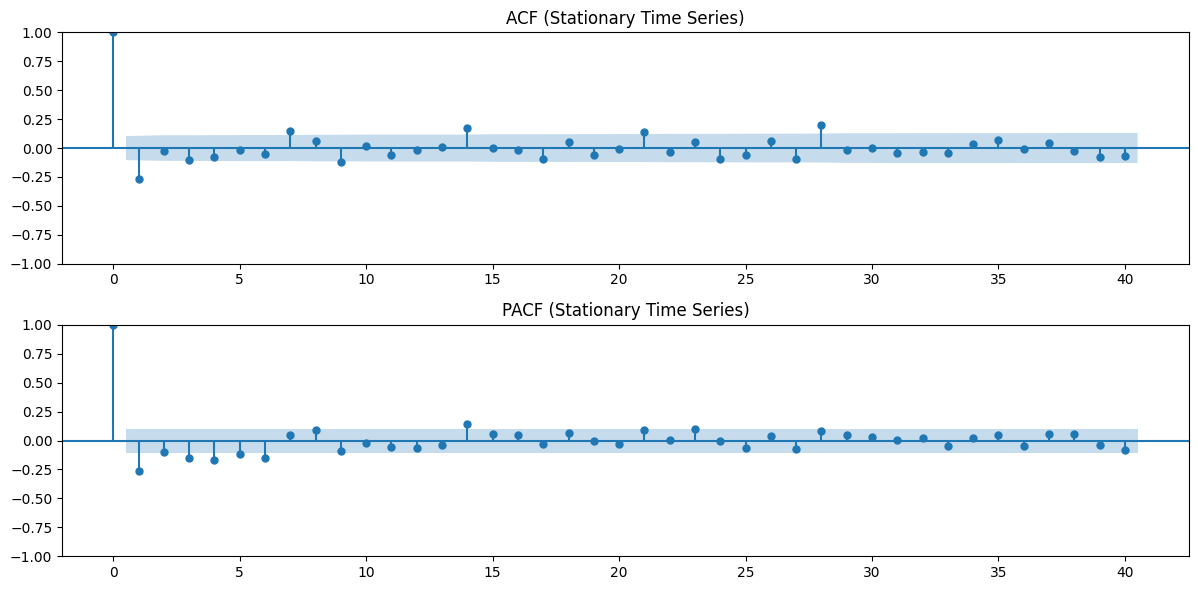

In [ ]:
#ACF and PACF before differencing
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(daily_d['Peak Day Value'].dropna(), lags=40, ax=plt.gca(), title='ACF (Original Time Series)')

plt.subplot(2, 1, 2)
plot_pacf(daily_d['Peak Day Value'].dropna(), lags=40, ax=plt.gca(), title='PACF (Original Time Series)')

plt.tight_layout()
plt.show()

#ACF and PACF after differencing
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(stationary_peak_day_value, lags=40, ax=plt.gca(), title='ACF (Stationary Time Series)')

plt.subplot(2, 1, 2)
plot_pacf(stationary_peak_day_value, lags=40, ax=plt.gca(), title='PACF (Stationary Time Series)')

plt.tight_layout()
plt.show()

SARIMA

Train/Test Split

In [ ]:
theta = (2 * np.pi * daily_d['Peak Day Hour']) / 24
daily_d['sine_hour'] = np.sin(theta)
daily_d['cosine_hour'] = np.cos(theta)

In [ ]:
end_of_october = daily_d.index.get_loc('2013-10-31')

In [ ]:
train_data = daily_d.iloc[:end_of_october+1]
test_data = daily_d.iloc[end_of_october+1:]

Parameters

In [ ]:
#Best parameters for sine_hour
params_sine = auto_arima(train_data['sine_hour'], seasonal=True, m=7,
                              trace=True, suppress_warnings=True, stepwise=True, max_order=None)

#Best parameters for cosine_hour
params_cosine = auto_arima(train_data['cosine_hour'], seasonal=True, m=7,
                                trace=True, suppress_warnings=True, stepwise=True, max_order=None)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=-438.952, Time=3.48 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-270.150, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-341.902, Time=0.32 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-446.868, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-272.150, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-448.576, Time=0.16 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-446.856, Time=0.76 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-444.857, Time=0.67 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-446.645, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=-446.650, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-343.709, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=-444.651, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[7]             : AIC=-450.545, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[7]             : AIC=-448.825, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[7]          

In [ ]:
print(params_sine.summary())
print(params_cosine.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  297
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 227.272
Date:                Fri, 25 Aug 2023   AIC                           -450.545
Time:                        16:59:26   BIC                           -443.164
Sample:                    01-08-2013   HQIC                          -447.589
                         - 10-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9346      0.027    -35.168      0.000      -0.987      -0.883
sigma2         0.0125      0.000     84.025      0.000       0.012       0.013
Ljung-Box (L1) (Q):                   0.04   Jarque-

Model Fit & Predict

In [ ]:
model_sine = pm.ARIMA(order=params_sine.order, seasonal_order=params_sine.seasonal_order)
results_sine = model_sine.fit(train_data['sine_hour'])
forecast_sine = results_sine.predict(n_periods=61)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
model_cosine = pm.ARIMA(order=params_cosine.order, seasonal_order=params_cosine.seasonal_order)
results_cosine = model_cosine.fit(train_data['sine_hour'])
forecast_cosine = results_cosine.predict(n_periods=61)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
#Converting sine and cosine forecasts back to hour format
predicted_hours = [np.arctan2(sin_val, cos_val) * (12/np.pi) for sin_val, cos_val in zip(forecast_sine, forecast_cosine)]
predicted_hours = [round(hour) if hour >= 0 else round(hour + 24) for hour in predicted_hours]

Performance Metrics

In [ ]:
#MAE and MAPE
mae = mean_absolute_error(test_data['Peak Day Hour'], predicted_hours)
mape = np.mean(np.abs((test_data['Peak Day Hour'] - predicted_hours) / test_data['Peak Day Hour'])) * 100

print(f"Forecast MAE: {mae}")
print(f"Forecast MAPE: {mape}%")

Forecast MAE: 2.9836065573770494
Forecast MAPE: 16.610227584761912%


Plot

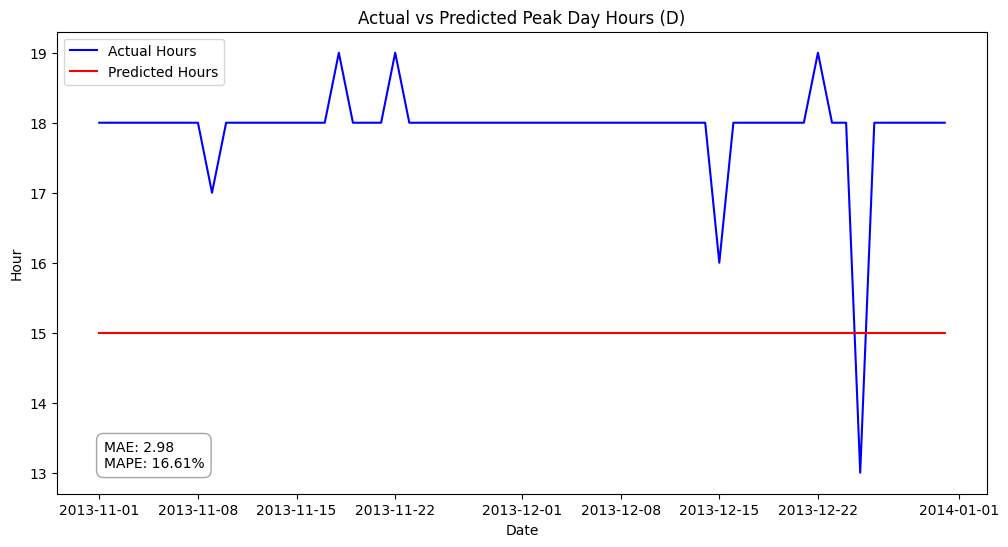

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Peak Day Hour'], label="Actual Hours", color='blue')
plt.plot(test_data.index, predicted_hours, label="Predicted Hours", color='red')
plt.legend(loc='best')
plt.title("Actual vs Predicted Peak Day Hours (D)")
plt.xlabel("Date")
plt.ylabel("Hour")

textstr = f'MAE: {mae:.2f}\nMAPE: {mape:.2f}%'

props = dict(boxstyle='round, pad=0.5', facecolor='white', edgecolor='gray', alpha=0.7)

plt.text(0.05, 0.05, textstr, transform=plt.gca().transAxes, verticalalignment='bottom', bbox=props)
plt.show()

In [ ]:
results_df = pd.DataFrame({
    'Date': test_data.index[:61],
    'Actual Hour': test_data['Peak Day Hour'].values[:61],
    'Predicted Hour': predicted_hours[:61]
})


results_df['Actual Hour'] = results_df['Actual Hour'].apply(lambda x: '{:.2f}'.format(x))
results_df['Predicted Hour'] = results_df['Predicted Hour'].apply(lambda x: '{:.2f}'.format(x))

results_df['Difference (%)'] = ((results_df['Predicted Hour'].astype(float) - results_df['Actual Hour'].astype(float)) / results_df['Actual Hour'].astype(float)) * 100

results_df['Difference (%)'] = results_df['Difference (%)'].apply(lambda x: '{:.2f}%'.format(x))

print(results_df)

         Date Actual Hour Predicted Hour Difference (%)
0  2013-11-01       18.00          15.00        -16.67%
1  2013-11-02       18.00          15.00        -16.67%
2  2013-11-03       18.00          15.00        -16.67%
3  2013-11-04       18.00          15.00        -16.67%
4  2013-11-05       18.00          15.00        -16.67%
..        ...         ...            ...            ...
56 2013-12-27       18.00          15.00        -16.67%
57 2013-12-28       18.00          15.00        -16.67%
58 2013-12-29       18.00          15.00        -16.67%
59 2013-12-30       18.00          15.00        -16.67%
60 2013-12-31       18.00          15.00        -16.67%

[61 rows x 4 columns]
